<a href="https://colab.research.google.com/github/Bibhash123/Resizing_factor_estimation/blob/main/UCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Notebook For Detection of whether image is resized or not for Uncompressed images**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import cv2
import os
import numpy as np
from sklearn.utils import shuffle
import random
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

In [ ]:
def seedAll(seed=355):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ["PYTHONHASHSEED"]=str(seed)

seedAll()

In [ ]:
PATH ='/content/gdrive/My Drive/Sync/ML4E-Forensics/uncompressed/UNcompressed/'
CAND_RF = [0.5,0.6,0.7,0.8,0.9,1.1,1.2,1.3,1.4,1.5]
CROP_SIZE = 128

In [ ]:
def extract_images(img,crop_size=256):
    images = []
    for i in range(crop_size,img.shape[0],crop_size):
        for j in range(crop_size,img.shape[1],crop_size):
            images.append(img[i-crop_size:i,j-crop_size:j,:])
    return images

def crop_img(img):

  img = img[0:CROP_SIZE,0:CROP_SIZE,0]
  return img

In [ ]:
images = []
total = len(os.listdir(PATH))
test = []

for id,img in enumerate(os.listdir(PATH)):
  print(f'\rProgress: {(id+1)*100/total} %',end='',flush=True)
  try:
    image = cv2.cvtColor(cv2.imread(PATH+img),cv2.COLOR_BGR2YCrCb)
    temp = extract_images(image)
    test = test+temp[0::20]
    del temp[0::20]
    images = images+temp
  except:
    pass

Progress: 100.0 %

In [ ]:
print(f"train+val set size: {len(images)}")
print(f"holdout set size: {len(test)}")

train+val set size: 12689
holdout set size: 690


In [ ]:
def prepare_data(images,rfs=CAND_RF):
  l = int(len(images)/10)
  to_be_rs = images[:l]
  img_shape = images[0].shape

  resized_images = []
  print(f'Resizing {l} images with {len(rfs)} candidate factors')
  for id,img in enumerate(to_be_rs):
    print(f'\rProgress: {(id+1)*100/l} %',end='',flush=True)
    for factor in rfs:
      rs_size = (int(img_shape[0]*factor),int(img_shape[1]*factor))
      rs_img = cv2.resize(img,rs_size,interpolation=cv2.INTER_CUBIC)
      resized_images.append(rs_img)
  
  labels = [[1,0] for i in range(len(images))]+[[0,1] for i in range(len(resized_images))]
  images = images+resized_images

  print(f'\nCropping images to size ({CROP_SIZE},{CROP_SIZE})')
  for id,img in enumerate(images):
    print(f'\rProgress: {(id+1)*100/len(images)} %',end='',flush=True)
    images[id] = np.expand_dims(crop_img(img),axis=2)
  images,labels = shuffle(images,labels,random_state=101)
  return np.stack(images),np.array(labels)

X,Y = prepare_data(images)
del images

Resizing 1268 images with 10 candidate factors
Progress: 100.0 %
Cropping images to size (128,128)
Progress: 100.0 %

In [ ]:
X_test,Y_test = prepare_data(test)
del test

Resizing 69 images with 10 candidate factors
Progress: 100.0 %
Cropping images to size (128,128)
Progress: 100.0 %

In [ ]:
print(f"final train+val set size: {len(X)}")
print(f"final holdout set size: {len(X_test)}")

final train+val set size: 25369
final holdout set size: 1380


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.2,random_state=1001)

In [ ]:
def build_model():
  inp = L.Input(shape=(128,128,1))
  out = L.Conv2D(32,(3,3),activation="relu",kernel_initializer="lecun_normal")(inp)
  side = out
  out = L.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(out)
  out = L.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(out)


  out = L.Add()([out,side])
  out = L.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(out)
  side2 = out
  out = L.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(out)
  out = L.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(out)
  out = L.MaxPooling2D(pool_size=(2,2))(out)
  
  side2 = L.Conv2D(64,(1,1),strides=2,activation=None)(side2)
  out = L.Add()([out,side2])
  out = L.GlobalAveragePooling2D()(out)
  out = L.Dense(120,activation="relu",kernel_initializer="he_normal")(out)
  out = L.Dense(50,activation="relu",kernel_initializer="he_normal",kernel_regularizer=tf.keras.regularizers.L2(0.01))(out)
  out = L.Dense(2,activation="softmax",kernel_initializer="he_normal")(out)

  model = tf.keras.Model(inputs=inp,outputs=out)
  model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adamax(lr=0.001),metrics=["accuracy"])
  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 126, 126, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 126, 126, 32) 9248        conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 126, 126, 32) 9248        conv2d_8[0][0]                   
_______________________________________________________________________________________

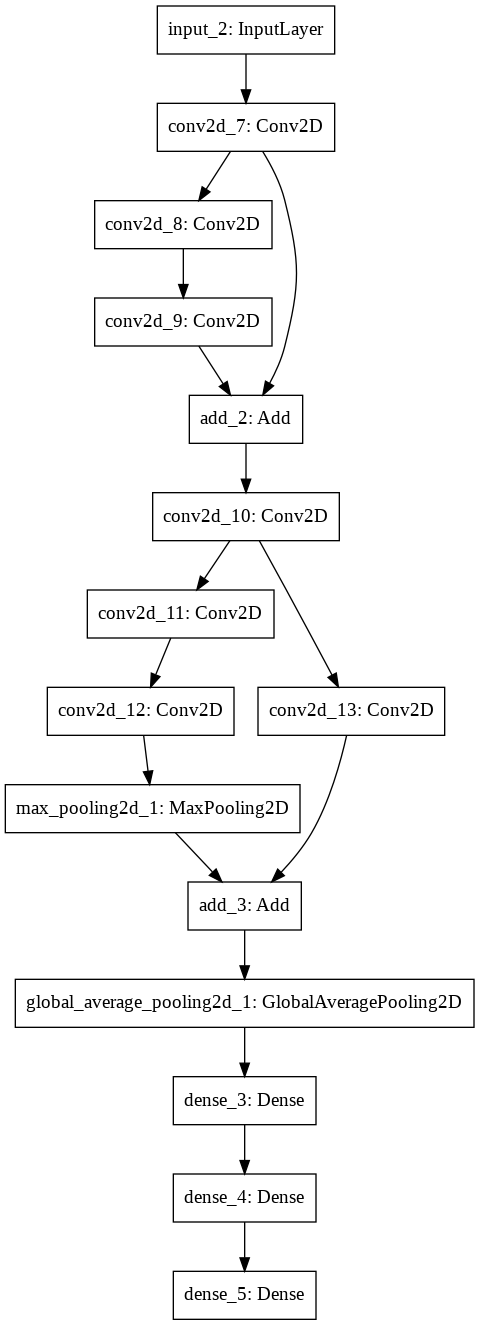

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
chckpt = tf.keras.callbacks.ModelCheckpoint('model.hdf5',save_best_only=True,save_weights_only=True,monitor="val_accuracy",mode="max")

In [ ]:
from IPython.display import clear_output
class loss_plt(tf.keras.callbacks.Callback):
  def on_train_begin(self,logs={}):
    self.losses = []
    self.val_losses =[]
    self.accuracy = []
    self.val_accuracy =[]

  def on_epoch_end(self,epoch,logs={}):
    clear_output(wait=True)
    self.val_losses.append(logs.get('val_loss'))
    self.losses.append(logs.get('loss'))

    self.val_accuracy.append(logs.get('val_accuracy'))
    self.accuracy.append(logs.get('accuracy'))

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(self.val_losses,color="green",label="val_loss")
    plt.plot(self.losses,color="red",label="loss")
    plt.legend()
    plt.title("loss curve");

    plt.subplot(1,2,2)
    plt.plot(self.val_accuracy,color="green",label="val_accuracy")
    plt.plot(self.accuracy,color="red",label="accuracy")
    plt.legend()
    plt.title("accuracy curve");
    plt.tight_layout()
    plt.show()

loss_cback = loss_plt()

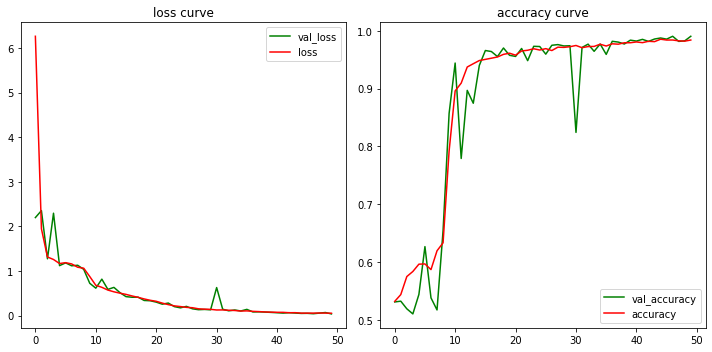

318/318 [==============================] - 81s 255ms/step - loss: 0.0535 - accuracy: 0.9840 - val_loss: 0.0383 - val_accuracy: 0.9905


In [ ]:
history = model.fit(X_train,Y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_val,Y_val),
                    callbacks=[chckpt,loss_cback],verbose=1
                    )

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
#model.load_weights('model.hdf5')
pred = model.predict(X_test)
pred = [np.argmax(p) for p in pred]

In [ ]:
y = [np.argmax(p) for p in Y_test]

In [ ]:
print(confusion_matrix(y,pred))
print(classification_report(y,pred))

[[683   7]
 [  5 685]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       690
           1       0.99      0.99      0.99       690

    accuracy                           0.99      1380
   macro avg       0.99      0.99      0.99      1380
weighted avg       0.99      0.99      0.99      1380



In [ ]:
test_img = cv2.cvtColor(cv2.imread('re08ec168t.TIF'),cv2.COLOR_BGR2YCrCb)
t = test_img[:256,:256,:]
ur = np.expand_dims(t[:128,:128,0],axis=2)

In [ ]:
model.predict(np.stack([ur]))

array([[1.0000000e+00, 4.5219883e-10]], dtype=float32)

In [ ]:
t_r = cv2.resize(t,(int(0.5*t.shape[0]),int(0.5*t.shape[1])),interpolation=cv2.INTER_CUBIC)
r = np.expand_dims(t_r[:128,:128,0],axis=2)

In [ ]:
model.predict(np.stack([r]))

array([[0.03209999, 0.9679    ]], dtype=float32)